In [1]:
#
# Working through the example at
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_12_multexp_conc_diffreact.py
#

In [2]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.MultipleExperimentsEstimator import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [3]:
#=========================================================================
#     SIMULATION MODEL   1
#=========================================================================
# First we will look to generate our data for each of our components in order
# to build the C-matrix that we desire. We will look to give our species different
# noise levels in order to also test whether the scaling for multiple levels works
builder = TemplateBuilder()    
builder.add_mixture_component('A',0.5)
builder.add_mixture_component('B',0.0)
builder.add_mixture_component('C',0.0)
builder.add_mixture_component('D',0.01)
builder.add_mixture_component('E',0.0)
builder.add_mixture_component('F',0.3)
builder.add_mixture_component('G',0.5)
builder.add_mixture_component('H',0.0)

#Following this we add the kinetic parameters
builder.add_parameter('k1',0.3)
builder.add_parameter('k2',0.1)
builder.add_parameter('k3',0.1)
builder.add_parameter('k4',0.4)
builder.add_parameter('k5',0.02)
builder.add_parameter('k6',0.5)
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']-m.P['k4']*m.Z[t,'A']- m.P['k5']*m.Z[t,'E']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']-m.P['k3']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']-m.P['k4']*m.Z[t,'C']
    exprs['D'] = m.P['k4']*m.Z[t,'A']-m.P['k3']*m.Z[t,'D']
    exprs['E'] = m.P['k3']*m.Z[t,'B'] - m.P['k5']*m.Z[t,'E']*m.Z[t,'A']

    exprs['F'] = m.P['k5']*m.Z[t,'E']*m.Z[t,'A'] - m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']
    exprs['G'] = -m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']
    exprs['H'] = m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']
    return exprs
#builder.add_concentration_data(D_frame)
#Add these ODEs to our model template
builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,20.0) 

In [4]:
# Once the model is described we run the simulator

# call FESimulator
# FESimulator re-constructs the current TemplateBuilder into fe_factory syntax
# there is no need to call PyomoSimulator any more as FESimulator is a child class 
sim = PyomoSimulator(opt_model)

# defines the discrete points wanted in the concentration profile
sim.apply_discretization('dae.collocation', nfe=50, ncp=3, scheme='LAGRANGE-RADAU')

#this will allow for the fe_factory to run the element by element march forward along 
#the elements and also automatically initialize the PyomoSimulator model, allowing
#for the use of the run_sim() function as before. We only need to provide the inputs 
#to this function as an argument dictionary
options = {'linear_solver':'ma27'}
init = sim.run_sim(solver = 'ipopt', tee = True, solver_opts = options)

Ipopt 3.13.2: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    10058
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      450

Total number of variables............................:     2408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2408
T

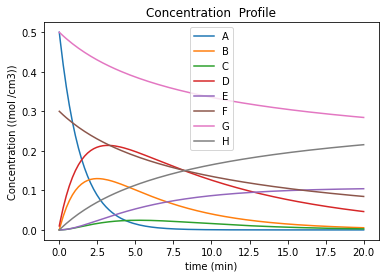

In [5]:
init.Z.plot.line(legend=True)
plt.xlabel("time (min)")
plt.ylabel("Concentration ((mol /cm3))")
plt.title("Concentration  Profile")

plt.show()

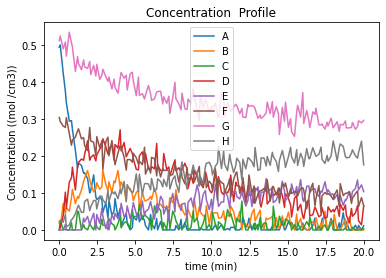

In [6]:
data = add_noise_to_signal(init.Z,0.02)
       
data.plot.line(legend=True)
plt.xlabel("time (min)")
plt.ylabel("Concentration ((mol /cm3))")
plt.title("Concentration  Profile")
plt.show()

In [9]:
 write_concentration_data_to_csv('../data_sets/multiexp_conc_sim_data.csv',data)

In [11]:
#=========================================================================
#     SIMULATION MODEL   2
#=========================================================================
# First we will look to generate our data for each of our components in order
# to build the C-matrix that we desire. We will look to give our species different
# noise levels in order to also test whether the scaling for multiple levels works
builder1 = TemplateBuilder()    
builder1.add_mixture_component('A',0.3)
builder1.add_mixture_component('B',0.0)
builder1.add_mixture_component('C',0.0)
builder1.add_mixture_component('D',0.1)
builder1.add_mixture_component('E',0.0)
builder1.add_mixture_component('F',0.5)
builder1.add_mixture_component('G',0.8)
builder1.add_mixture_component('H',0.0)  

#Following this we add the kinetic parameters
builder1.add_parameter('k1',0.3)
builder1.add_parameter('k2',0.1)
builder1.add_parameter('k3',0.1)
builder1.add_parameter('k4',0.4)
builder1.add_parameter('k5',0.02)
builder1.add_parameter('k6',0.5)
# define explicit system of ODEs
#builder.add_concentration_data(D_frame)
#Add these ODEs to our model template
builder1.set_odes_rule(rule_odes)
opt_model1 = builder1.create_pyomo_model(0.0,20.0) 

In [12]:
# Once the model is described we run the simulator

# call FESimulator
# FESimulator re-constructs the current TemplateBuilder into fe_factory syntax
# there is no need to call PyomoSimulator any more as FESimulator is a child class 
sim1 = PyomoSimulator(opt_model1)

# defines the discrete points wanted in the concentration profile
sim1.apply_discretization('dae.collocation', nfe=50, ncp=3, scheme='LAGRANGE-RADAU')

#this will allow for the fe_factory to run the element by element march forward along 
#the elements and also automatically initialize the PyomoSimulator model, allowing
#for the use of the run_sim() function as before. We only need to provide the inputs 
#to this function as an argument dictionary
init1 = sim1.run_sim(solver = 'ipopt', tee = True, solver_opts = {'linear_solver':'ma27'})

Ipopt 3.13.2: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    10058
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      450

Total number of variables............................:     2408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2408
T

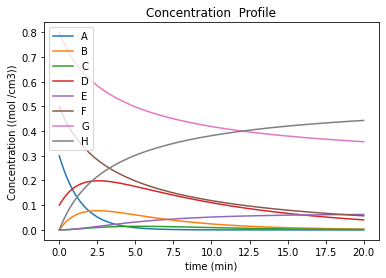

In [13]:
init1.Z.plot.line(legend=True)
plt.xlabel("time (min)")
plt.ylabel("Concentration ((mol /cm3))")
plt.title("Concentration  Profile")

plt.show()

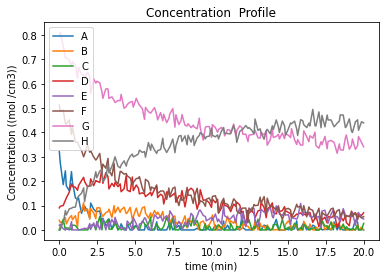

In [14]:
data2 = add_noise_to_signal(init1.Z,0.02)

data2.plot.line(legend=True)
plt.xlabel("time (min)")
plt.ylabel("Concentration ((mol /cm3))")
plt.title("Concentration  Profile")

plt.show()

In [15]:
 write_concentration_data_to_csv('../data_sets/multiexp_conc_sim_data1.csv',data2)

In [16]:
# Load spectral data from the file location. 
#################################################################################

D_frame1 = read_concentration_data_from_csv('../data_sets/multiexp_conc_sim_data.csv')
D_frame2 = read_concentration_data_from_csv('../data_sets/multiexp_conc_sim_data1.csv')

In [17]:
# Then we build dae block for as described in the section 4.2.1. Note the addition
# of the data using .add_concentration_data
#################################################################################  

#=========================================================================
# USER INPUT SECTION - Parameter Estimation
#=========================================================================
builder = TemplateBuilder()    
builder.add_mixture_component('A',0.5)
builder.add_mixture_component('B',0.0)
builder.add_mixture_component('C',0.0)
builder.add_mixture_component('D',0.01)
builder.add_mixture_component('E',0.0)
builder.add_mixture_component('F',0.3)
builder.add_mixture_component('G',0.5)
builder.add_mixture_component('H',0.0)

#Following this we add the kinetic parameters
builder.add_parameter('k1',bounds=(0.0,1))
builder.add_parameter('k2',bounds=(0.0,1))
builder.add_parameter('k3',bounds=(0.0,1))
builder.add_parameter('k4',bounds=(0.0,1))
builder.add_parameter('k5',init=0.2,bounds=(0.0,1))
builder.add_parameter('k6',bounds=(0.0,1))
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']-m.P['k4']*m.Z[t,'A']- m.P['k5']*m.Z[t,'E']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']-m.P['k3']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']-m.P['k4']*m.Z[t,'C']
    exprs['D'] = m.P['k4']*m.Z[t,'A']-m.P['k3']*m.Z[t,'D']
    exprs['E'] = m.P['k3']*m.Z[t,'B'] - m.P['k5']*m.Z[t,'E']*m.Z[t,'A']

    exprs['F'] = m.P['k5']*m.Z[t,'E']*m.Z[t,'A'] - m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']
    exprs['G'] = -m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']
    exprs['H'] = m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']

    return exprs
#builder.add_concentration_data(D_frame1)

#Add these ODEs to our model template
builder.set_odes_rule(rule_odes)

In [18]:
builder1 = TemplateBuilder()    

builder1.add_mixture_component('A',0.3)
builder1.add_mixture_component('B',0.0)
builder1.add_mixture_component('C',0.0)
builder1.add_mixture_component('D',0.1)
builder1.add_mixture_component('E',0.0)
builder1.add_mixture_component('F',0.5)
builder1.add_mixture_component('G',0.8)
builder1.add_mixture_component('H',0.0)   
#Following this we add the kinetic parameters
builder1.add_parameter('k1',init=0.2,bounds=(0.0,1))
builder1.add_parameter('k2',init=0.2,bounds=(0.0,1))
builder1.add_parameter('k3',init=0.05,bounds=(0.0,1))
builder1.add_parameter('k4',init=0.5,bounds=(0.0,1))
builder1.add_parameter('k5',init=0.2,bounds=(0.0,1))
builder1.add_parameter('k6',init=0.45,bounds=(0.0,1))

#builder.add_concentration_data(D_frame2)
def rule_odes1(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']-m.P['k4']*m.Z[t,'A']- m.P['k5']*m.Z[t,'E']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']-m.P['k3']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']-m.P['k4']*m.Z[t,'C']
    exprs['D'] = m.P['k4']*m.Z[t,'A']-m.P['k3']*m.Z[t,'D']
    exprs['E'] = m.P['k3']*m.Z[t,'B'] - m.P['k5']*m.Z[t,'E']*m.Z[t,'A']

    exprs['F'] = m.P['k5']*m.Z[t,'E']*m.Z[t,'A'] - m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']
    exprs['G'] = -m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']
    exprs['H'] = m.P['k6']*m.Z[t,'G']**2*m.Z[t,'F']

    return exprs
#Add these ODEs to our model template
builder1.set_odes_rule(rule_odes1)

start_time = {'Exp1':0.0, 'Exp2':0.0}
end_time = {'Exp1':20.0, 'Exp2':20.0}    
datasets = {'Exp1': D_frame1, 'Exp2': D_frame2}
sigmas = {'A':1e-10,'B':1e-10,'C':1e-11, 'D':1e-11,'E':1e-11,'F':1e-11,'G':1e-11,'H':1e-11,'device':0.02}
variances = {'Exp1':sigmas, 'Exp2':sigmas}
builder_dict = {'Exp1':builder, 'Exp2':builder1}


In [19]:
options = dict()
options['linear_solver'] = 'ma27'
#options['mu_init']=1e-6

In [21]:
# ============================================================================
#   USER INPUT SECTION - MULTIPLE EXPERIMENTAL DATASETS       
# ===========================================================================
# Here we use the class for Multiple experiments, notice that we add the dictionary
# Containing the datasets here as an argument
pest = MultipleExperimentsEstimator(datasets)

nfe = 50
ncp = 3

# Finally we run the parameter estimation. This solves each dataset separately first and then
# links the models and solves it simultaneously
results_pest = pest.run_parameter_estimation(solver = 'ipopt', 
                                                    tee=True,
                                                     nfe=nfe,
                                                     ncp=ncp,
                                                     covariance = False,
                                                     solver_opts = options,
                                                     start_time=start_time, 
                                                     end_time=end_time,
                                                     spectra_problem = False,
                                                     sigma_sq=variances,
                                                     builder = builder_dict)


SOLVING PARAMETER ESTIMATION FOR INDIVIDUAL DATASETS - For initialization

Solving for DATASET  Exp1
initial values: 0.0, G
initial values: 0.0, E
initial values: 0.0, A
initial values: 0.0, B
initial values: 0.0, F
initial values: 0.0, D
initial values: 0.0, C
initial values: 0.0, H
    number of finite elements specified in apply. The larger number of finite
    elements will be used.
Ipopt 3.13.2: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    37358
Number of nonzeros in inequality constraint Jacobian.:     

The estimated parameters are:
k1 0.3265360972873727
k2 0.10506811177492785
k3 0.09434484160341804
k4 0.3808456378556773
k5 1.0
k6 0.5035322880751457

SOLVING PARAMETER ESTIMATION FOR MULTIPLE DATASETS

Fixed parameters are:  []
Ipopt 3.13.2: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    77146
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    13816

Total number of variables............................:    14430
                     variable

  79  1.9999979e-01 3.92e+10 7.53e+01  -1.0 1.63e+00    -  1.81e-01 2.46e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.9999980e-01 3.93e+10 7.49e+02  -1.0 3.52e+00    -  3.98e-01 1.32e-02h  3
  81  2.0000004e-01 5.39e+10 2.65e+04  -1.0 1.98e+00    -  1.96e-01 8.06e-02w  1
  82  2.0000021e-01 4.45e+10 4.29e+04  -1.0 2.96e-01    -  1.00e+00 1.00e+00w  1
  83  2.0000136e-01 8.75e+10 1.77e+05  -1.0 3.16e-01    -  9.45e-01 1.00e+00w  1
  84  1.9999983e-01 3.92e+10 7.86e+02  -1.0 3.09e-01    -  1.96e-01 1.01e-02h  3
  85  1.9999989e-01 3.91e+10 4.66e+03  -1.0 1.94e+00    -  2.80e-01 3.42e-03h  5
  86  2.0000006e-01 3.91e+10 3.41e+04  -1.0 1.55e+01    -  4.06e-02 2.01e-04h  6
  87  2.0000037e-01 3.91e+10 3.47e+05  -1.0 1.46e+01    -  6.72e-02 5.65e-05h  8
  88r 2.0000037e-01 3.91e+10 1.00e+03   2.6 0.00e+00    -  0.00e+00 2.70e-07R 13
  89r 5.3257269e-01 1.04e+11 9.83e+02   2.6 3.06e+05    -  3.05e-02 1.27e-03f  1
iter    objective    inf_pr 

 178  1.1449463e+00 3.99e+10 8.64e+01  -1.0 7.31e-01    -  1.72e-02 3.54e-01h  2
 179  1.1409893e+00 3.98e+10 8.61e+01  -1.0 3.62e+01    -  2.36e-02 4.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.1390020e+00 3.97e+10 1.05e+02  -1.0 2.87e+00    -  2.07e-01 2.11e-03h  2
 181  1.1356428e+00 3.97e+10 3.77e+02  -1.0 6.37e+00    -  2.36e-01 3.58e-03h  4
 182  1.1348617e+00 3.97e+10 6.18e+02  -1.0 1.20e+01    -  7.73e-02 8.35e-04h  5
 183  1.1341207e+00 3.97e+10 1.84e+03  -1.0 1.18e+01    -  2.97e-01 7.93e-04h  5
 184  1.1333912e+00 3.97e+10 8.35e+03  -1.0 1.13e+01    -  7.77e-02 7.81e-04h  5
 185  1.1330884e+00 3.97e+10 3.17e+05  -1.0 1.27e+01    -  4.01e-01 3.24e-04h  6
 186  1.1328233e+00 3.97e+10 1.33e+06  -1.0 1.39e+01    -  3.14e-02 2.87e-04h  6
 187  1.1326893e+00 3.97e+10 3.74e+06  -1.0 6.11e+00    -  3.88e-02 1.47e-04h  8
 188  1.1323301e+00 3.97e+10 4.78e+07  -1.0 1.58e+01    -  9.63e-02 4.69e-04h  5
 189  1.1323601e+00 3.97e+10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  2.0076104e-01 3.72e+10 3.14e+07  -1.0 1.06e+00    -  1.98e-01 2.26e-05h  3
 271  2.0236647e-01 3.70e+10 3.88e+07  -1.0 1.05e+00    -  2.23e-01 1.21e-02h  5
MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 2219890 to 4439780 and la from 2894228 to 5788894 and factorize again.
 272  2.0612847e-01 3.70e+10 5.47e+07  -1.0 4.03e+00    -  1.48e-01 9.08e-03h  4
MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 4439780 to 8879560 and la from 5788894 to 11600304 and factorize again.
 273  2.0726699e-01 3.70e+10 6.41e+07  -1.0 3.43e+00    -  2.48e-01 1.42e-02h  4
 274  2.0786716e-01 3.72e+10 8.25e+07  -1.0 2.03e+00    -  7.10e-01 2.10e-02h  4
 275  1.9969154e-01 4.73e+11 2.10e+10  -1.0 2.40e+00    -  1.19e-01 3.23e-01w  1
  Signal handler called from  /opt/anaconda3/envs/kipetenv/lib/python3.7/subprocess.py _try_wait 1611
  Waiting...
  Signaled process 588 with signal 

ApplicationError: Solver (ipopt) did not exit normally

In [24]:
import platform
platform.system(), platform.machine(), platform.platform()

('Darwin', 'x86_64', 'Darwin-17.7.0-x86_64-i386-64bit')

In [ ]:
for k,v in results_pest.items():
    print(results_pest[k].P)

In [ ]:
for k,v in results_pest.items():

    results_pest[k].C.plot.line(legend=True)
    plt.xlabel("time (s)")
    plt.ylabel("Concentration (mol/L)")
    plt.title("Concentration Profile")

    results_pest[k].Z.plot.line(legend=True)
    plt.xlabel("time (s)")
    plt.ylabel("Concentration (mol/L)")
    plt.title("Concentration Profile")

    plt.show()